In [73]:
import sys
sys.path.insert(0, '../')

# module imports
import pandas as pd
import numpy
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from collections import Counter
from itertools import chain
import ast
import random
from datetime import datetime
from importlib import reload

# local imports
from fit_model import fit
import BERT
import build_dataset
import baseline
import fit_model

# reload modules
reload(BERT)
reload(build_dataset)
reload(baseline)
reload(fit_model)


# For reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

## Load the data

genereate synthetic data

In [74]:
# from build_synthetic_data_frames import constant_loc_distinct, random_loc_distinct, ten_sequence_loc_constant, weekly_location_cycle
# # Generate synthetic data for 100 users over 10 days
# df = weekly_location_cycle(100, 100, 100)
# # group by user and sort by date
# df.sort_values(by=['user', 'date']).head(30)

or use the real data

In [75]:
# load data from csv
DATASET_PATH = "../../data/final_data_200.csv"
df = pd.read_csv(DATASET_PATH)

In [76]:
# filter user 0.0 and concatenate the df to itself 100 times
# df = df[df.user <= 5]
# df = pd.concat([df]*2, ignore_index=True)

In [77]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from tqdm import tqdm

BATCH_SIZE = 8 
num_workers = 4


# Function for setting seed (assuming it's defined)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)


# split data into train, val, test
train_df, val_df, test_df = build_dataset.stratified_user_week_split(df, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15, ensure_user_in_all_sets=True)

# compute ranks for each user based on the train set
rank_dict = build_dataset.compute_rank_dict(train_df)

# create vocabulary based on the whole dataset
dataset = build_dataset.BertMobilityDataset(df,rank_dict)
vocab = dataset.vocab 

# Initialize the datasets with the rank dictionary and vocabulary
train_dataset = build_dataset.BertMobilityDataset(train_df,rank_dict, vocab)
val_dataset = build_dataset.BertMobilityDataset(val_df, rank_dict, vocab)
test_dataset = build_dataset.BertMobilityDataset(test_df, rank_dict, vocab)

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, worker_init_fn=seed_worker, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, num_workers=num_workers)

In [78]:
# check dataset stats
print(train_dataset.calculate_max_sequence_length(), val_dataset.calculate_max_sequence_length(), test_dataset.calculate_max_sequence_length())
print(len(train_df), len(val_df), len(test_df))
print(train_dataset.calculate_avg_sequence_length(), val_dataset.calculate_avg_sequence_length(), test_dataset.calculate_avg_sequence_length())

189 161 159
170336 36512 36492
23.903452147067078 23.70909090909091 23.604139715394567


In [79]:
train_dataset[0]

{'y': tensor([   1,   11,    9,   11,    9,   11,    9,   11,    9,   11,    9,   11,
            9,   11,    9, 1110,   11,    9,   11,    9,   11,    9,   11,    9,
            6,   11,    7,   11, 3246,   11,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,   

## Train the model

In [80]:
import copy
import BERT  # Assuming BERT is a module you've defined

def make_model(ntokens_location, ntokens_user, vocab_sizes, emb_sizes, use_fusion_embeddings=False,
               n_layers=6, d_model=512, d_ff=2048, n_heads=8, dropout=0.1):
    """
    Helper: Construct a model from hyperparameters.
    """
    c = copy.deepcopy
    attn = BERT.MultiHeadedAttention(n_heads, d_model)
    ff = BERT.PositionwiseFeedForward(d_model, d_ff, dropout)
    position = BERT.PositionalEncoding(d_model, dropout)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Choose the embedding layer based on the flag
    if use_fusion_embeddings:
        src_embed = nn.Sequential(BERT.ModifiedFusionEmbeddings(d_model, ntokens_location, ntokens_user, vocab_sizes, emb_sizes, device), c(position))
    else:
        src_embed = nn.Sequential(BERT.ModifiedEmbeddings(d_model, ntokens_location, ntokens_user), c(position))

    model = BERT.BERT_model(
        BERT.Encoder(BERT.EncoderLayer(d_model, c(attn), c(ff), dropout), n_layers),
        src_embed,
        d_model, ntokens_location
    )
    
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)  # Note the underscore for in-place operation
    return model


In [81]:
# Import necessary libraries
import torch
import torch.nn as nn
import baseline  
import BERT  
import fit_model  

# Set device based on CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dataset and vocabulary parameters
vocab = train_dataset.vocab
max_rank = dataset.df['rank'].max()
ntokens_user = train_dataset.users.astype(int).max() + 1  # len(train_dataset.users) + 4 todo: change user labels according to max user id + 4 special tkoens
ntokens_location = len(vocab)
print('ntokens_user:', ntokens_user)
print('ntokens_location:', ntokens_location)

# Model hyperparameters
epochs = 100 
d_model = 32
vocab_sizes = [ntokens_location, max_rank+1]  # Additional feature vocab sizes [ntokens_location, max_rank+1,25,8]
emb_sizes = [d_model, 8]          # Additional feature embedding sizes
d_hid = 32  
nlayers = 1  
nhead = 2  
dropout = 0  
lr = 0.001  
use_fusion_embeddings = True 

# Model initialization
print("\nInitializing model with the following parameters:")
print(f"  Epochs: {epochs}")
print(f"  d_model: {d_model}")
print(f"  vocab_sizes: {vocab_sizes}")
print(f"  emb_sizes: {emb_sizes}")
print(f"  d_hid (d_ff): {d_hid}")
print(f"  nlayers: {nlayers}")
print(f"  nhead: {nhead}")
print(f"  Dropout: {dropout}")
print(f"  Learning Rate: {lr}")
print(f"  Use Fusion Embeddings: {use_fusion_embeddings}")

model = make_model(ntokens_location=ntokens_location,
                   ntokens_user=ntokens_user,
                   vocab_sizes=vocab_sizes,
                   emb_sizes=emb_sizes,
                   use_fusion_embeddings=use_fusion_embeddings,
                   n_layers=nlayers,
                   d_model=d_model,
                   d_ff=d_hid,
                   n_heads=nhead,
                   dropout=dropout)

# Get user-defined variant string
variant = input("Enter a variant string: ")
print(f"Training name: {variant}")

# Initialize baseline model
bl_simple = baseline.BaselineModel(train_dataset, ntokens_location)
bl_sampled = baseline.BaselineModelSampled(train_dataset, ntokens_location)
bl_markov_1 = baseline.BaselineModelMarkov1(train_dataset, ntokens_location)


# GPU setup for multi-GPU environments
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

# Move model to the specified device
model.to(device)

# Optimizer setup
opt = torch.optim.Adam(model.parameters(), lr=lr) #  removed betas=(0.9, 0.98)
#opt = NoamOpt(d_hid, 1, 4000, torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

# Model training and evaluation
print("\nStarting training and evaluation...")
measures_train = fit_model.fit(model, opt, train_loader, val_loader, epochs, ntokens_location, bl_simple, bl_sampled, bl_markov_1, use_fusion_embeddings)

# Unpack training and validation measures
train_loss_list, train_accuracy_list, validation_loss_list, val_accuracy_list, val_baseline_simple_accuracy_list, val_baseline_sampled_accuracy_list, val_baseline_markov_1_accuracy_list = measures_train

Using device: cpu
ntokens_user: 829
ntokens_location: 6265

Initializing model with the following parameters:
  Epochs: 100
  d_model: 32
  vocab_sizes: [6265, 62]
  emb_sizes: [32, 8]
  d_hid (d_ff): 32
  nlayers: 1
  nhead: 2
  Dropout: 0
  Learning Rate: 0.001
  Use Fusion Embeddings: True
Training name: bert_user


# Save results


In [ ]:
variant

'bert_user_time'

In [ ]:
torch.save(model, f"../saved_models/{variant}.pt")

In [ ]:
test_model = torch.load(f"../saved_models/{variant}.pt")

In [ ]:
import evaluate_model
reload(evaluate_model)

# Save model configuration
model_config = {
    'ntokens': int(ntokens_location),
    'epochs': epochs,
    'd_model': d_model,
    'd_hid': d_hid,
    'nlayers': nlayers,
    'nhead': nhead,
    'dropout': dropout,
    'lr': lr,
    'device': device.type
}
evaluate_model.save_model_data( measures_train, model_config, variant)

Saved measures to ../../output/training_measures_bert_user_time.json, and config to ../../output/model_config_bert_user_time.json


In [ ]:
# # load model data
# variant = input("Enter the variant string: ")
# from evaluate_model import load_model_data

# measures, config = load_model_data(model, variant)

# # # extract data from the JSON
# measures_tuple = tuple(measures[key] for key in sorted(measures.keys()))
# baseline_loss_list, train_accuracy_list, train_loss_list, val_accuracy_list, val_baseline_accuracy_list, validation_loss_list  = measures_tuple


In [ ]:
# compute the average validation accuracy for the last 100 epochs
print('average validation accuracy for the last 20 epochs', np.mean(val_accuracy_list[-20:])) 

average validation accuracy for the last 20 epochs 0.20205124


# Plot results
todo: refactor plot code 

In [ ]:
fig_name =  variant + '.png'

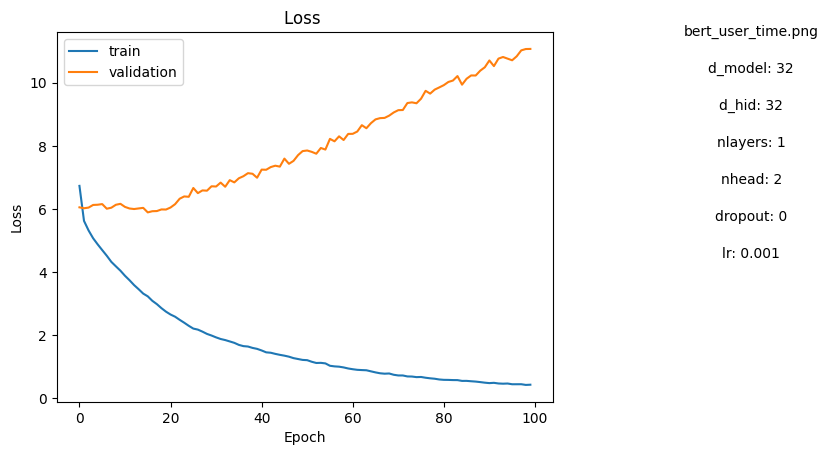

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label='train')
plt.plot(np.arange(len(validation_loss_list)), validation_loss_list, label='validation')

plt.title('Loss ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Add date to the plot
plt.text(1.4, 1.0, fig_name, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.text(1.4, 0.9, 'd_model: ' + str(d_model), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.4, 0.8, 'd_hid: ' + str(d_hid), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.4, 0.7, 'nlayers: ' + str(nlayers), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.4, 0.6, 'nhead: ' + str(nhead), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.4, 0.5, 'dropout: ' + str(dropout), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.4, 0.4, 'lr: ' + str(lr), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Save the plot
plt.savefig('../../figures/loss_' + fig_name , dpi=300, bbox_inches='tight')

# Show the plot (optional)
plt.show()


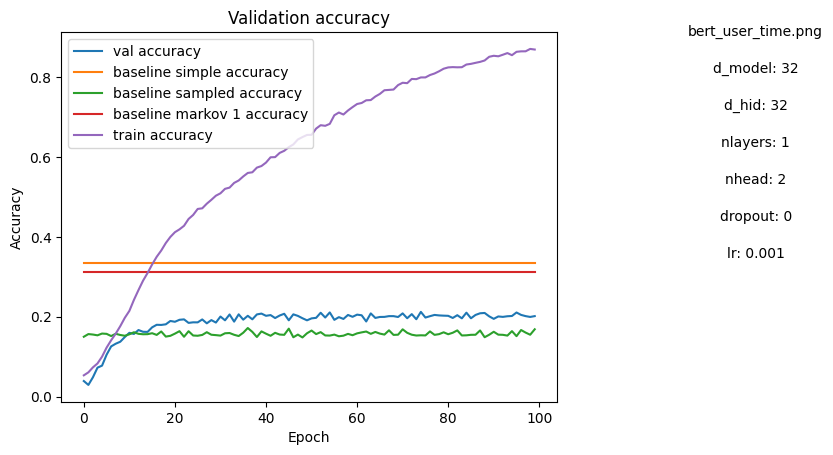

In [ ]:
from datetime import datetime

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
plt.plot(np.arange(len(val_accuracy_list)), val_accuracy_list, label='val accuracy')
plt.plot(np.arange(len(val_baseline_simple_accuracy_list)), val_baseline_simple_accuracy_list, label='baseline simple accuracy')
plt.plot(np.arange(len(val_baseline_sampled_accuracy_list)), val_baseline_sampled_accuracy_list, label='baseline sampled accuracy')
plt.plot(np.arange(len(val_baseline_markov_1_accuracy_list)), val_baseline_markov_1_accuracy_list, label='baseline markov 1 accuracy')
plt.plot(np.arange(len(train_accuracy_list)), train_accuracy_list, label='train accuracy')


plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Add date to the plot
plt.text(1.4, 1.0, fig_name, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.4, 0.9, 'd_model: ' + str(d_model), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.4, 0.8, 'd_hid: ' + str(d_hid), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.4, 0.7, 'nlayers: ' + str(nlayers), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.4, 0.6, 'nhead: ' + str(nhead), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.4, 0.5, 'dropout: ' + str(dropout), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.4, 0.4, 'lr: ' + str(lr), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Save the plot
plt.savefig('../../figures/accuracy_' + fig_name, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

